# Convolutional Neural Network
We use a supervised convolutional neural network in this file to classify images into five categories.

## CNN (no_epochs = 10, batch_size = 32) on original datasets
### Import the necessary libraries

In [1]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, f1_score
from PIL import Image
import matplotlib.pyplot as plt
import platform
from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, Sequential, Conv2d, LeakyReLU, BatchNorm2d, MaxPool2d, Dropout, Linear, ReLU, CrossEntropyLoss

### Use gpu on Mac
Computers with Intel chips can use `torch.cuda.is_availabe` to run on GPU. However, the newest Mac computers use Apple M1/M2 chips instead of Intel chips. Thus, we can use `torch.backends.mps.is_built()` to run on GPU.

In [2]:
has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

Python Platform: macOS-12.6-arm64-arm-64bit
MPS (Apple Metal) is AVAILABLE
Target device is mps


### Define the hyperparameters
In the following part, we define the following hyperparameters.
- `no_classes`: the number of classes
- `no_epoches`: the number of times the entire data set is passed forward and backward through the neural network
- `batch_size`: the number of samples used in one forward and backward pass through the network
- `learning_rate`: a tuning parameter in an optimization algorithm that determines the step size at each iteration while moving toward a minimum of a loss function
Initially, `no_classes` is 5, `no_epoches` is 10, `batch_size` is 32, and `learning_rate` is 0.001

In [3]:
no_classes = 5
no_epochs = 10
batch_size = 32
learning_rate = 0.001

### Other preparation

In [4]:
img_path = 'final_dataset'
label_map = {
    'bar': 0,
    'beach': 1,
    'bookstore': 2,
    'restaurant': 3,
    'subway': 4
}
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    normalize
])

### ImageDataset class
This ImageDataset class is used with `DataLoader` to load images with proper labels. The ImageDataset class must have `__len__` and `__getitem__` methods to cooperate `DataLoader`. 

In [5]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, label_map, transform=None):
        self.img_dir = img_dir
        self.label_map = label_map
        self.transform = transform
        self.images = []
        self.labels = []
        
        for name, num in label_map.items():
            for img_name in os.listdir(os.path.join(img_dir, name)):
                img_path = os.path.join(img_dir, name, img_name)
                self.images.append(img_path)
                self.labels.append(num)
            print(f"finish to read all {name} images")

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

### Load images and split into the training sets and testing sets

In [6]:
dataset = ImageDataset(img_path, label_map, transform=transforms)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

finish to read all bar images
finish to read all beach images
finish to read all bookstore images
finish to read all restaurant images
finish to read all subway images


### CNNModel class
This class defines the neural network layers and fully connected layers. 
#### Neural network layers
`Conv2d` defines a convolutional neural network:
- `in_channels`: Initially, the input channel is 3 because of RGB images. Other input channels need to be matched with the previous output channel.
- `out_channels`: output channel
- `kernel_size`: we use 3*3 kernel to calculate matrix multiplication
- `stride`: we do not jump pixels when we move the kernel.
- `padding`: we add one pixel of padding around the input images

`BatchNorm2d`: batch normalization to normalize the input of each layer so that they have a mean of zero and a standard deviation of one

`LeakyReLU`: activation function

`MaxPool2d`: The max pooling layer picks the max value inside the windows 2*2.
#### Fully connected layers
- `Dropout`: there is a 10% chance that any given input unit will be set to zero during training.
- `Linear`: linear layers perform a linear transformation on the input data.
- `ReLU`: activation function
#### Size changes
Initial input: 3 * 64 * 64 (64*64 pixels, RGB images)
- After `Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)`: 32 * 64 * 64 (output channel is 32)
- After `MaxPool2d(stride=2, kernel_size=2)` of layer 1: 32 * 32 * 32 ((64 pixels/2 kernel_size) * (64 pixels/2 kernel_size))
- After `Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)`: 64 * 32 * 32 (output channel is 64)
- After `MaxPool2d(stride=2, kernel_size=2)` of layer 2: 64 * 16 * 16
- After `Linear(64*16*16, 1000)`: 1000
- After `Linear(1000, 512)`: 512
- After `Linear(512, no_classes)`: 5
#### Forward
Go through the neural network layers, flatten the images and go through the fully connected layers.

In [7]:
class CNNModel(Module):
    def __init__(self, no_classes):
        super(CNNModel, self).__init__()
        self.layer1 = Sequential(
            Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            LeakyReLU(inplace=True),
            Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            LeakyReLU(inplace=True),
            MaxPool2d(stride=2, kernel_size=2)
        )
        self.layer2 = Sequential(
            Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(64),
            LeakyReLU(inplace=True),
            Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(64),
            LeakyReLU(inplace=True),
            MaxPool2d(stride=2, kernel_size=2)
        )
        self.fc1 = Sequential(
            Dropout(p=0.1),
            Linear(64*16*16, 1000),
            ReLU(inplace=True),
            Linear(1000, 512),
            ReLU(inplace=True),
            Dropout(p=0.1),
            Linear(512, no_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out

### Define the model, loss function and Optimizer

In [8]:
model = CNNModel(no_classes).to(device)
criterion = CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Train the model

In [9]:
for epoch in range(no_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 20 == 0:
            print(f"Epoch: {epoch+1}/{no_epochs}, Step: {i+1}/{len(train_loader)}, Loss: {loss.item()}")


Epoch: 1/10, Step: 20/74, Loss: 1.7593152523040771
Epoch: 1/10, Step: 40/74, Loss: 1.350690484046936
Epoch: 1/10, Step: 60/74, Loss: 0.8875124454498291
Epoch: 2/10, Step: 20/74, Loss: 1.062715768814087
Epoch: 2/10, Step: 40/74, Loss: 1.175614833831787
Epoch: 2/10, Step: 60/74, Loss: 0.7874146699905396
Epoch: 3/10, Step: 20/74, Loss: 0.9164423942565918
Epoch: 3/10, Step: 40/74, Loss: 0.8590799570083618
Epoch: 3/10, Step: 60/74, Loss: 1.096989393234253
Epoch: 4/10, Step: 20/74, Loss: 0.5966579914093018
Epoch: 4/10, Step: 40/74, Loss: 0.6036208271980286
Epoch: 4/10, Step: 60/74, Loss: 0.6840654611587524
Epoch: 5/10, Step: 20/74, Loss: 0.6483210325241089
Epoch: 5/10, Step: 40/74, Loss: 0.8504898548126221
Epoch: 5/10, Step: 60/74, Loss: 0.6045224666595459
Epoch: 6/10, Step: 20/74, Loss: 0.7056102156639099
Epoch: 6/10, Step: 40/74, Loss: 0.6022103428840637
Epoch: 6/10, Step: 60/74, Loss: 0.7532510161399841
Epoch: 7/10, Step: 20/74, Loss: 1.357702374458313
Epoch: 7/10, Step: 40/74, Loss: 0.69

### Evaluation

Overall Accuracy: 0.6892; Precision: 0.6839; Recall: 0.6692; F1: 0.6560
Class bar - Accuracy: 0.3109; Precision: 0.6379; Recall: 0.3109; F1-score: 0.4181
Class beach - Accuracy: 0.9517; Precision: 0.9650; Recall: 0.9517; F1-score: 0.9583
Class bookstore - Accuracy: 0.7578; Precision: 0.8509; Recall: 0.7578; F1-score: 0.8017
Class restaurant - Accuracy: 0.4725; Precision: 0.4574; Recall: 0.4725; F1-score: 0.4649
Class subway - Accuracy: 0.8532; Precision: 0.5082; Recall: 0.8532; F1-score: 0.6370


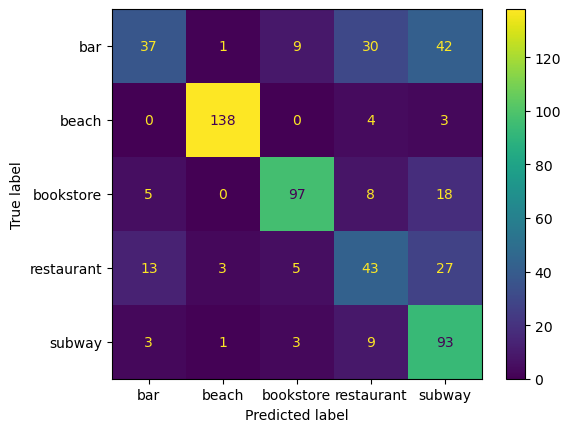

In [10]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    predicted_labels = []
    true_labels = []
    class_correct = [0] * len(label_map)
    class_total = [0] * len(label_map)

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    print(f"Overall Accuracy: {accuracy:.4f}; Precision: {precision:.4f}; Recall: {recall:.4f}; F1: {f1:.4f}")

    for i in range(len(label_map)):
        class_acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        class_prec = precision_score(true_labels, predicted_labels, labels=[i], average='macro', zero_division=0)
        class_rec = recall_score(true_labels, predicted_labels, labels=[i], average='macro', zero_division=0)
        class_f1 = f1_score(true_labels, predicted_labels, labels=[i], average='macro', zero_division=0)
        print(f"Class {list(label_map.keys())[i]} - Accuracy: {class_acc:.4f}; Precision: {class_prec:.4f}; Recall: {class_rec:.4f}; F1-score: {class_f1:.4f}")

    conf_matrix = confusion_matrix(true_labels, predicted_labels)    
    confusion_matrix_display = ConfusionMatrixDisplay(conf_matrix, display_labels=label_map.keys())
    confusion_matrix_display.plot()
    plt.show()

## CNN (no_epochs = 20, batch_size = 128) on original datasets

Python Platform: macOS-12.6-arm64-arm-64bit
MPS (Apple Metal) is AVAILABLE
Target device is mps
finish to read all bar images
finish to read all beach images
finish to read all bookstore images
finish to read all restaurant images
finish to read all subway images
Epoch: 1/20, Step: 5/19, Loss: 1.8465126752853394
Epoch: 1/20, Step: 10/19, Loss: 1.4934883117675781
Epoch: 1/20, Step: 15/19, Loss: 1.2615196704864502
Epoch: 2/20, Step: 5/19, Loss: 1.0854649543762207
Epoch: 2/20, Step: 10/19, Loss: 1.1746265888214111
Epoch: 2/20, Step: 15/19, Loss: 1.0872015953063965
Epoch: 3/20, Step: 5/19, Loss: 1.0449962615966797
Epoch: 3/20, Step: 10/19, Loss: 0.9551957845687866
Epoch: 3/20, Step: 15/19, Loss: 1.051969051361084
Epoch: 4/20, Step: 5/19, Loss: 0.7859195470809937
Epoch: 4/20, Step: 10/19, Loss: 1.0345380306243896
Epoch: 4/20, Step: 15/19, Loss: 0.9722411036491394
Epoch: 5/20, Step: 5/19, Loss: 0.8509674072265625
Epoch: 5/20, Step: 10/19, Loss: 0.8737387657165527
Epoch: 5/20, Step: 15/19, Lo

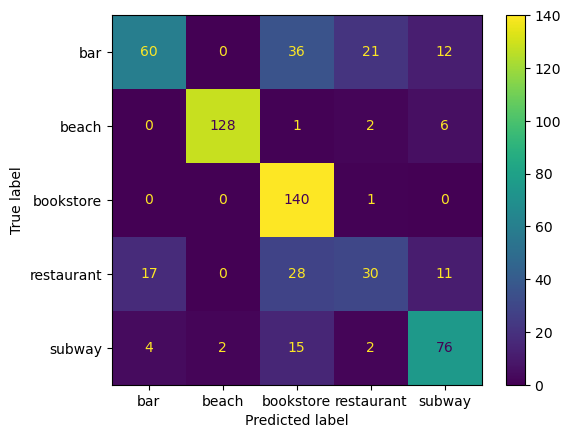

In [11]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, f1_score
from PIL import Image
import matplotlib.pyplot as plt
import platform
from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, Sequential, Conv2d, LeakyReLU, BatchNorm2d, MaxPool2d, Dropout, Linear, ReLU, CrossEntropyLoss

has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

no_classes = 5
no_epochs = 20
batch_size = 128
learning_rate = 0.001
img_path = 'final_dataset'
label_map = {
    'bar': 0,
    'beach': 1,
    'bookstore': 2,
    'restaurant': 3,
    'subway': 4
}
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    normalize
])

class ImageDataset(Dataset):
    def __init__(self, img_dir, label_map, transform=None):
        self.img_dir = img_dir
        self.label_map = label_map
        self.transform = transform
        self.images = []
        self.labels = []
        
        for name, num in label_map.items():
            for img_name in os.listdir(os.path.join(img_dir, name)):
                img_path = os.path.join(img_dir, name, img_name)
                self.images.append(img_path)
                self.labels.append(num)
            print(f"finish to read all {name} images")

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

dataset = ImageDataset(img_path, label_map, transform=transforms)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class CNNModel(Module):
    def __init__(self, no_classes):
        super(CNNModel, self).__init__()
        self.layer1 = Sequential(
            Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            LeakyReLU(inplace=True),
            Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            LeakyReLU(inplace=True),
            MaxPool2d(stride=2, kernel_size=2)
        )
        self.layer2 = Sequential(
            Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(64),
            LeakyReLU(inplace=True),
            Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(64),
            LeakyReLU(inplace=True),
            MaxPool2d(stride=2, kernel_size=2)
        )
        self.fc1 = Sequential(
            Dropout(p=0.1),
            Linear(64*16*16, 1000),
            ReLU(inplace=True),
            Linear(1000, 512),
            ReLU(inplace=True),
            Dropout(p=0.1),
            Linear(512, no_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out
    
model = CNNModel(no_classes).to(device)
criterion = CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(no_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 5 == 0:
            print(f"Epoch: {epoch+1}/{no_epochs}, Step: {i+1}/{len(train_loader)}, Loss: {loss.item()}")

        
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    predicted_labels = []
    true_labels = []
    class_correct = [0] * len(label_map)
    class_total = [0] * len(label_map)

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    print(f"Overall Accuracy: {accuracy:.4f}; Precision: {precision:.4f}; Recall: {recall:.4f}; F1: {f1:.4f}")

    for i in range(len(label_map)):
        class_acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        class_prec = precision_score(true_labels, predicted_labels, labels=[i], average='macro', zero_division=0)
        class_rec = recall_score(true_labels, predicted_labels, labels=[i], average='macro', zero_division=0)
        class_f1 = f1_score(true_labels, predicted_labels, labels=[i], average='macro', zero_division=0)
        print(f"Class {list(label_map.keys())[i]} - Accuracy: {class_acc:.4f}; Precision: {class_prec:.4f}; Recall: {class_rec:.4f}; F1-score: {class_f1:.4f}")

    conf_matrix = confusion_matrix(true_labels, predicted_labels)    
    confusion_matrix_display = ConfusionMatrixDisplay(conf_matrix, display_labels=label_map.keys())
    confusion_matrix_display.plot()
    plt.show()


## CNN (no_epochs = 20, batch_size = 128) on augmented datasets
`img_path = 'final_dataset_augmentated'`

Python Platform: macOS-12.6-arm64-arm-64bit
MPS (Apple Metal) is AVAILABLE
Target device is mps
finish to read all bar images
finish to read all beach images
finish to read all bookstore images
finish to read all restaurant images
finish to read all subway images
Epoch: 1/20, Step: 5/20, Loss: 3.6358585357666016
Epoch: 1/20, Step: 10/20, Loss: 1.733208179473877
Epoch: 1/20, Step: 15/20, Loss: 1.1863327026367188
Epoch: 1/20, Step: 20/20, Loss: 1.2460956573486328
Epoch: 2/20, Step: 5/20, Loss: 1.1683796644210815
Epoch: 2/20, Step: 10/20, Loss: 1.0623867511749268
Epoch: 2/20, Step: 15/20, Loss: 1.040144681930542
Epoch: 2/20, Step: 20/20, Loss: 1.019327998161316
Epoch: 3/20, Step: 5/20, Loss: 0.9077842831611633
Epoch: 3/20, Step: 10/20, Loss: 0.7947403192520142
Epoch: 3/20, Step: 15/20, Loss: 0.8352148532867432
Epoch: 3/20, Step: 20/20, Loss: 0.7618057131767273
Epoch: 4/20, Step: 5/20, Loss: 0.778712809085846
Epoch: 4/20, Step: 10/20, Loss: 0.6773592233657837
Epoch: 4/20, Step: 15/20, Loss

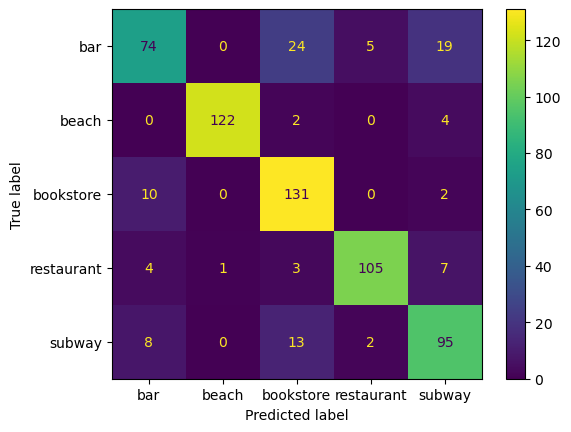

In [12]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, f1_score
from PIL import Image
import matplotlib.pyplot as plt
import platform
from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, Sequential, Conv2d, LeakyReLU, BatchNorm2d, MaxPool2d, Dropout, Linear, ReLU, CrossEntropyLoss

has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

no_classes = 5
no_epochs = 20
batch_size = 128
learning_rate = 0.001
img_path = 'final_dataset_augmentated'
label_map = {
    'bar': 0,
    'beach': 1,
    'bookstore': 2,
    'restaurant': 3,
    'subway': 4
}
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    normalize
])

class ImageDataset(Dataset):
    def __init__(self, img_dir, label_map, transform=None):
        self.img_dir = img_dir
        self.label_map = label_map
        self.transform = transform
        self.images = []
        self.labels = []
        
        for name, num in label_map.items():
            for img_name in os.listdir(os.path.join(img_dir, name)):
                img_path = os.path.join(img_dir, name, img_name)
                self.images.append(img_path)
                self.labels.append(num)
            print(f"finish to read all {name} images")

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

dataset = ImageDataset(img_path, label_map, transform=transforms)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class CNNModel(Module):
    def __init__(self, no_classes):
        super(CNNModel, self).__init__()
        self.layer1 = Sequential(
            Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            LeakyReLU(inplace=True),
            Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            LeakyReLU(inplace=True),
            MaxPool2d(stride=2, kernel_size=2)
        )
        self.layer2 = Sequential(
            Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(64),
            LeakyReLU(inplace=True),
            Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(64),
            LeakyReLU(inplace=True),
            MaxPool2d(stride=2, kernel_size=2)
        )
        self.fc1 = Sequential(
            Dropout(p=0.1),
            Linear(64*16*16, 1000),
            ReLU(inplace=True),
            Linear(1000, 512),
            ReLU(inplace=True),
            Dropout(p=0.1),
            Linear(512, no_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out
    
model = CNNModel(no_classes).to(device)
criterion = CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(no_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 5 == 0:
            print(f"Epoch: {epoch+1}/{no_epochs}, Step: {i+1}/{len(train_loader)}, Loss: {loss.item()}")

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    predicted_labels = []
    true_labels = []
    class_correct = [0] * len(label_map)
    class_total = [0] * len(label_map)

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    print(f"Overall Accuracy: {accuracy:.4f}; Precision: {precision:.4f}; Recall: {recall:.4f}; F1: {f1:.4f}")

    for i in range(len(label_map)):
        class_acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        class_prec = precision_score(true_labels, predicted_labels, labels=[i], average='macro', zero_division=0)
        class_rec = recall_score(true_labels, predicted_labels, labels=[i], average='macro', zero_division=0)
        class_f1 = f1_score(true_labels, predicted_labels, labels=[i], average='macro', zero_division=0)
        print(f"Class {list(label_map.keys())[i]} - Accuracy: {class_acc:.4f}; Precision: {class_prec:.4f}; Recall: {class_rec:.4f}; F1-score: {class_f1:.4f}")

    conf_matrix = confusion_matrix(true_labels, predicted_labels)    
    confusion_matrix_display = ConfusionMatrixDisplay(conf_matrix, display_labels=label_map.keys())
    confusion_matrix_display.plot()
    plt.show()
